# UQ on MML Datasets (3D)

## Load Libraries

In [1]:
import sys

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from monai.transforms import RandFlipd, Compose, RandAffined, ScaleIntensityd, LoadImage

from landmarker.transforms.images import UseOnlyFirstChannel

In [ ]:
sys.path.append('../training')

from datasets.mml import get_mml_dataset

## Load data

In [ ]:
path_dir = "../data"

In [4]:
inference_transform = Compose([
    ScaleIntensityd(keys=["image"], dtype=None)
])

In [5]:
train_dataset, val_dataset, test_dataset = get_mml_dataset(
                                                        path_dir,
                                                        train_extended=False,
                                                        original_crop=True,
                                                        benchmark=False,
                                                        kind="mask",
                                                        train_transform=inference_transform,
                                                        inference_transform=inference_transform,
                                                        store_imgs=False,
                                                    )

In [6]:
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=5, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=5, shuffle=False)

## Model Initialization

In [ ]:
from models.shr import StaticHeatmapRegression
from landmarker.losses import NLLLoss
from landmarker.models.utils import SoftmaxND
from monai.transforms import RandAffine

from glob import glob

from monai.networks.nets import FlexibleUNet
from copy import deepcopy

nb_landmarks = train_dataset.nb_landmarks
MC_inference_samples = 20

one_hot_decoder_method = "local_soft_argmax"
one_hot_heatmap_model = StaticHeatmapRegression(
    model = FlexibleUNet(
        in_channels = 1,
        out_channels = 14,
        backbone= "efficientnet-b0",
        pretrained=True,
        decoder_channels= [128, 128, 128, 128, 128],
        spatial_dims=3,
        dropout=0.5,
        act="relu",
    ),
    loss = NLLLoss(spatial_dims=3),
    final_activation = SoftmaxND(spatial_dims=3),
    decoder_method=one_hot_decoder_method,
    spatial_dims=3,
    covariance_decoder_method="weighted_sample_covariance"
)
state_dict_one_hot = torch.load("../results/lightning_model_checkpoints/MML/MML_shr_unet.ckpt", map_location="cpu")["state_dict"]
one_hot_heatmap_model.load_state_dict(state_dict_one_hot)
one_hot_heatmap_model_mc = deepcopy(one_hot_heatmap_model)
one_hot_heatmap_model_mc.MC_dropout = True
one_hot_heatmap_model_mc.MC_inference_samples = MC_inference_samples

ensemble_ckpts = glob("../results/lightning_model_checkpoints/MML/ensemble/*.ckpt")
one_hot_heatmap_model_ensemble = StaticHeatmapRegression(
    model = FlexibleUNet(
        in_channels = 1,
        out_channels = 14,
        backbone= "efficientnet-b0",
        pretrained=True,
        decoder_channels= [128, 128, 128, 128, 128],
        spatial_dims=3,
        dropout=0.5,
        act="relu",
    ),
    loss = NLLLoss(spatial_dims=3),
    final_activation = SoftmaxND(spatial_dims=3),
    decoder_method=one_hot_decoder_method,
    ensemble=True,
    ensemble_ckpts = ensemble_ckpts,
    spatial_dims=3,
    covariance_decoder_method="weighted_sample_covariance"
)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'final_activation' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['final_activation'])`.
/tmp/ipykernel_1894/1710397844.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possibl

In [8]:
import lightning as L

trainer = L.Trainer(accelerator="gpu", logger=None)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Producing prediction regions
Approaches to conformalize the landmark prediction task:
* Ellipsoidal prediction regions using the mahalanobis distance as nonconformity measure and use covariance matrix (prefarbly adaptive)
* Statistical correction
    1) Normalized absolute error, variance defined by MC-dropout, mc, ensemble
    2) Absolute error
* Maximum non-conformity measure
* Regression-as-classification approach (more a density based approach) (we extend it to the multi-ouput problem)

In [9]:
# Ensemble models for increased predictive performace
val_results_one_hot_ensemble = trainer.predict(one_hot_heatmap_model_ensemble, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
# Ensemble models for increased predictive performace
test_results_one_hot_ensemble = trainer.predict(one_hot_heatmap_model_ensemble, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

### Ellipsoidal Prediction Regions

In [11]:
sys.path.append('../..')

from src.uncertainty import *

In [12]:
one_hot_results = {}
confidence_level = 0.90
spatial_dims = 3
heatmap_size = (128, 128, 64)

In [13]:
print("="*100)
print("One-hot-encoded model")
print("="*100)

print(f"Fit and evaluate Ellipsoid CP regions with Ensemble (heatmap derived cov) for {100*confidence_level}%")
cp_mahalanobis_one_hot_ensemble_heatmap_cov = ConformalRegressorMahalanobis(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks)
cp_mahalanobis_one_hot_ensemble_heatmap_cov.fit(pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
                                  pred_cov=np.concatenate([result["covariance_orig_size"] for result in val_results_one_hot_ensemble]),
                                  target=val_dataset.landmarks)
one_hot_results["one_hot_ensemble_elliposoid_heatmap_cov"] = cp_mahalanobis_one_hot_ensemble_heatmap_cov.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level)
print("-"*50)


print(f"Fit and evaluate Bonferroni CP regions with Ensemble (heatmap derived sigma) for {100 * confidence_level}%")
cp_bonferroni_one_hot_ensemble_heatmap_sigma = ConformalRegressorBonferroni(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks)
cp_bonferroni_one_hot_ensemble_heatmap_sigma.fit(
    pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1, 2], [0, 1, 2]] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_bonferroni_heatmap_sigma"] = cp_bonferroni_one_hot_ensemble_heatmap_sigma.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1, 2], [0, 1, 2]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-" * 50)


print(f"Fit and evaluate Max Nonconformity CP regions with Ensemble (heatmap derived sigma) for {100*confidence_level}%")
cp_max_one_hot_ensemble_heatmap_sigma = ConformalRegressorMaxNonconformity(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks)
cp_max_one_hot_ensemble_heatmap_sigma.fit(pred=np.concatenate([result["landmarks_orig_size"] for result in val_results_one_hot_ensemble]),
                                  sigmas=np.concatenate([result["covariance_orig_size"][...,[0, 1, 2], [0, 1, 2]] for result in val_results_one_hot_ensemble]),
                                  target=val_dataset.landmarks)
one_hot_results["one_hot_ensemble_max_score_heatmap_sigma"] = cp_max_one_hot_ensemble_heatmap_sigma.evaluate(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0, 1, 2], [0, 1, 2]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level)
print("-"*50)

print(f"Fit and evaluate MR2CCP regions with Ensemble for {100*confidence_level}%")
mr2ccp_one_hot_ensemble = MR2CCP(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks,
                                heatmap_size=heatmap_size)
mr2ccp_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_mr2ccp"] = mr2ccp_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

print(f"Fit and evaluate MR2C2R regions with Ensemble for {100*confidence_level}%")
mr2c2r_one_hot_ensemble = MR2C2R(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks,
                                 heatmap_size=heatmap_size)
mr2c2r_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks
)
one_hot_results["one_hot_ensemble_mr2cr"] = mr2c2r_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

print(f"Fit and evaluate MR2C2R (APS) regions with Ensemble for {100*confidence_level}%")
mr2c2r_aps_one_hot_ensemble = MR2C2R(spatial_dims=spatial_dims, nb_landmarks=val_dataset.nb_landmarks,
                                                        aps=True, heatmap_size=heatmap_size)
mr2c2r_aps_one_hot_ensemble.fit(
    heatmaps=np.concatenate([result["heatmaps"] for result in val_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in val_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in val_results_one_hot_ensemble]),
    target=val_dataset.landmarks,
    confidence=confidence_level
)
one_hot_results["one_hot_ensemble_mr2c2r_aps"] = mr2c2r_aps_one_hot_ensemble.evaluate(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    pred_landmarks=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks,
    spacing=test_dataset.pixel_spacings.numpy(),
    confidence=confidence_level
)
print("-"*50)

One-hot-encoded model
Fit and evaluate Ellipsoid CP regions with Ensemble (heatmap derived cov) for 90.0%
Coverage: 0.8985714285714286
Efficiency (mean): 1303.6627197265625
Efficiency (median): 40.448360443115234
Efficiency (Q1): 18.19003677368164
Efficiency (Q3): 129.93516540527344
Adeptivity: 0.29478083261412746
--------------------------------------------------
Fit and evaluate Bonferroni CP regions with Ensemble (heatmap derived sigma) for 90.0%
Coverage: 0.9178571428571428
Efficiency (mean): 10054264.0
Efficiency (median): 174.7860565185547
Efficiency (Q1): 34.2730188369751
Efficiency (Q3): 2298.3411254882812
Adeptivity: 0.2636266476229252
--------------------------------------------------
Fit and evaluate Max Nonconformity CP regions with Ensemble (heatmap derived sigma) for 90.0%
Coverage: 0.9078571428571428
Efficiency (mean): 10870272.0
Efficiency (median): 224.0467529296875
Efficiency (Q1): 47.33353614807129
Efficiency (Q3): 2855.4273681640625
Adeptivity: 0.25320428807798956
-

100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Coverage: 0.8757142857142857
Efficiency (mean): 34.8294276552807
Efficiency (median): 29.087037563323975
Efficiency (Q1): 20.55200169607997
Efficiency (Q3): 42.82646518573165
Adeptivity: 0.28038657524542654
--------------------------------------------------
Fit and evaluate MR2C2R regions with Ensemble for 90.0%


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


Coverage: 0.8642857142857143
Efficiency (mean): 34.621370148366054
Efficiency (median): 27.96641856431961
Efficiency (Q1): 19.907513726502657
Efficiency (Q3): 43.154878072440624
Adeptivity: 0.27654454087306546
--------------------------------------------------
Fit and evaluate MR2C2R (APS) regions with Ensemble for 90.0%


100%|██████████| 100/100 [04:37<00:00,  2.77s/it]

Coverage: 0.8878571428571429
Efficiency (mean): 2032.0890205060425
Efficiency (median): 27.509841710329056
Efficiency (Q1): 17.26085353642702
Efficiency (Q3): 47.860675457865
Adeptivity: 0.33084874021580596
--------------------------------------------------


In [14]:
pred_contour_ellipse = (cp_mahalanobis_one_hot_ensemble_heatmap_cov.predict_contour(
                    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
                    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
                    confidence=confidence_level, sample_points=200) - 
                        np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                              ).reshape((len(test_results_one_hot_ensemble), nb_landmarks, 1, 1 , spatial_dims)))
in_region_ellipse = cp_mahalanobis_one_hot_ensemble_heatmap_cov.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    pred_cov=np.concatenate([result["covariance_orig_size"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_bonferroni_vertices, pred_bonferroni_faces = cp_bonferroni_one_hot_ensemble_heatmap_sigma.predict_contour(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1, 2], [0, 1, 2]] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)
pred_bonferroni_vertices = (pred_bonferroni_vertices - 
                            np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble])[:, :, np.newaxis, :])
in_region_bonferroni = cp_bonferroni_one_hot_ensemble_heatmap_sigma.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1, 2], [0,1, 2]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_max_vertices, pred_max_faces = cp_max_one_hot_ensemble_heatmap_sigma.predict_contour(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][..., [0, 1, 2], [0, 1, 2]] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)
pred_max_vertices = (pred_max_vertices- np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                              )[:, :, np.newaxis, :])
in_region_max_nonconformity = cp_max_one_hot_ensemble_heatmap_sigma.in_region(
    pred=np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]),
    sigmas=np.concatenate([result["covariance_orig_size"][...,[0,1,2], [0,1,2]] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    confidence=confidence_level
)

pred_contour_mr2ccp = mr2ccp_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2ccp = mr2ccp_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

pred_contour_mr2c2r = mr2c2r_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2c2r = mr2c2r_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

pred_contour_mr2c2r_aps = mr2c2r_aps_one_hot_ensemble.predict_contour(
                        heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
                        original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
                        padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
                        confidence=confidence_level)

in_region_mr2c2r_aps = mr2c2r_aps_one_hot_ensemble.in_region(
    heatmaps=np.concatenate([result["heatmaps"] for result in test_results_one_hot_ensemble]),
    target=test_dataset.landmarks.numpy(),
    original_dims=np.concatenate([result["original_dims"] for result in test_results_one_hot_ensemble]),
    padding=np.concatenate([result["padding"] for result in test_results_one_hot_ensemble]),
    confidence=confidence_level
)

Alert: contour caluculation is a lower bound


100%|██████████| 100/100 [04:26<00:00,  2.67s/it]


In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

def plot_single_landmark_sample(sample_idx, landmark_idx, save=False):
    blue = np.array([75/255, 157/255, 220/255])
    red = np.array([238/255, 111/255, 117/255])
    yellow = np.array([255/255, 208/255, 52/255, 1])
    
    # Error calculation
    error = (test_dataset.landmarks - np.concatenate(
        [result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
    ))[:, landmark_idx]
    
    titles = [
        "Statistical Correction",
        "Maximum Nonconformity",
        "Ellipsoidal Conformal Prediction",
        "M-R2CCP",
        "M-R2C2R",
        "M-R2C2R (APS)"
    ]
        
    
    fig = plt.figure(figsize=(12, 8))
    
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    ax1.set_title(titles[0], fontsize=12)
    color = yellow if in_region_bonferroni[sample_idx, landmark_idx] else red
    ax1.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color, label="True Point")
    ax1.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax1.add_collection3d(Poly3DCollection([pred_bonferroni_vertices[sample_idx, landmark_idx][pred_bonferroni_faces[j]] for j in range(len(pred_bonferroni_faces))], 
                                          linewidths=1, edgecolors='none', alpha=0.3, color=blue, label="Prediction Region"),
                        )
    ax1.set_box_aspect([1,1,1])
    ax1.legend(loc='upper left')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    
    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    ax2.set_title(titles[1], fontsize=12)
    color = yellow if in_region_max_nonconformity[sample_idx, landmark_idx] else red
    ax2.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color)
    ax2.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax2.add_collection3d(Poly3DCollection([pred_max_vertices[sample_idx, landmark_idx][pred_max_faces[j]] for j in range(len(pred_max_faces))], 
                                          linewidths=1, edgecolors='none', alpha=0.3, color=blue))
    ax2.set_box_aspect([1,1,1])
    set_axes_equal(ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    
    # Plot the ellipsoid surface
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    ax3.set_title(titles[2], fontsize=12)
    ax3.plot_surface(pred_contour_ellipse[sample_idx, landmark_idx,:,:, 2],
                    pred_contour_ellipse[sample_idx, landmark_idx,:,:, 1],
                    pred_contour_ellipse[sample_idx, landmark_idx,:,:, 0],
                    color=blue, alpha=0.3, edgecolor='none')
    color = yellow if in_region_ellipse[sample_idx, landmark_idx] else red
    ax3.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color)
    ax3.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax3.set_box_aspect([1,1,1])
    set_axes_equal(ax3)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('z')
    
    mr2ccp_vertices = (pred_contour_mr2ccp[sample_idx][landmark_idx][0] -
                      np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                  )[sample_idx, landmark_idx, np.newaxis, :])
    mr2ccp_faces = pred_contour_mr2ccp[sample_idx][landmark_idx][1]
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    ax4.set_title(titles[3], fontsize=12)
    color = yellow if in_region_mr2ccp[sample_idx, landmark_idx] else red
    ax4.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color)
    ax4.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax4.add_collection3d(Poly3DCollection(mr2ccp_vertices[mr2ccp_faces], 
                                          linewidths=0.01, edgecolors='none', alpha=0.3, color=blue))
    ax4.set_box_aspect([1,1,1])
    set_axes_equal(ax4)
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    ax4.set_zlabel('z')
    
    mr2c2r_vertices = (pred_contour_mr2c2r[sample_idx][landmark_idx][0] -
                      np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                  )[sample_idx, landmark_idx, np.newaxis, :])
    mr2c2r_faces = pred_contour_mr2c2r[sample_idx][landmark_idx][1]
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    ax5.set_title(titles[4], fontsize=12)
    color = yellow if in_region_mr2c2r[sample_idx, landmark_idx] else red
    ax5.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color)
    ax5.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax5.add_collection3d(Poly3DCollection(mr2c2r_vertices[mr2c2r_faces], 
                                          linewidths=0.01, edgecolors='none', alpha=0.3, color=blue))
    ax5.set_box_aspect([1,1,1])
    set_axes_equal(ax5)
    ax5.set_xlabel('x')
    ax5.set_ylabel('y')
    ax5.set_zlabel('z')
    
    mr2c2r_aps_vertices = (pred_contour_mr2c2r_aps[sample_idx][landmark_idx][0] -
                          np.concatenate([result["landmarks_orig_size"] for result in test_results_one_hot_ensemble]
                                  )[sample_idx, landmark_idx, np.newaxis, :])
    mr2c2r_aps_faces = pred_contour_mr2c2r_aps[sample_idx][landmark_idx][1]
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    ax6.set_title(titles[5], fontsize=12)
    color = yellow if in_region_mr2c2r[sample_idx, landmark_idx] else red
    ax6.scatter(error[sample_idx, 2], error[sample_idx, 1], error[sample_idx, 0],
                color=color)
    ax6.scatter(0, 0, 0, color="black", s=2, label="Point Prediction")
    ax6.add_collection3d(Poly3DCollection(mr2c2r_aps_vertices[mr2c2r_aps_faces], 
                                          linewidths=0.01, edgecolors='r', alpha=0.3, color=blue))
    ax6.set_box_aspect([1,1,1])
    set_axes_equal(ax6)
    ax6.set_xlabel('x')
    ax6.set_ylabel('y')
    ax6.set_zlabel('z')
    
    if save:
        plt.savefig(f"MML3D_landmark_{landmark_idx}_sample_{sample_idx}_error_analysis.pdf", bbox_inches="tight")
    plt.show()

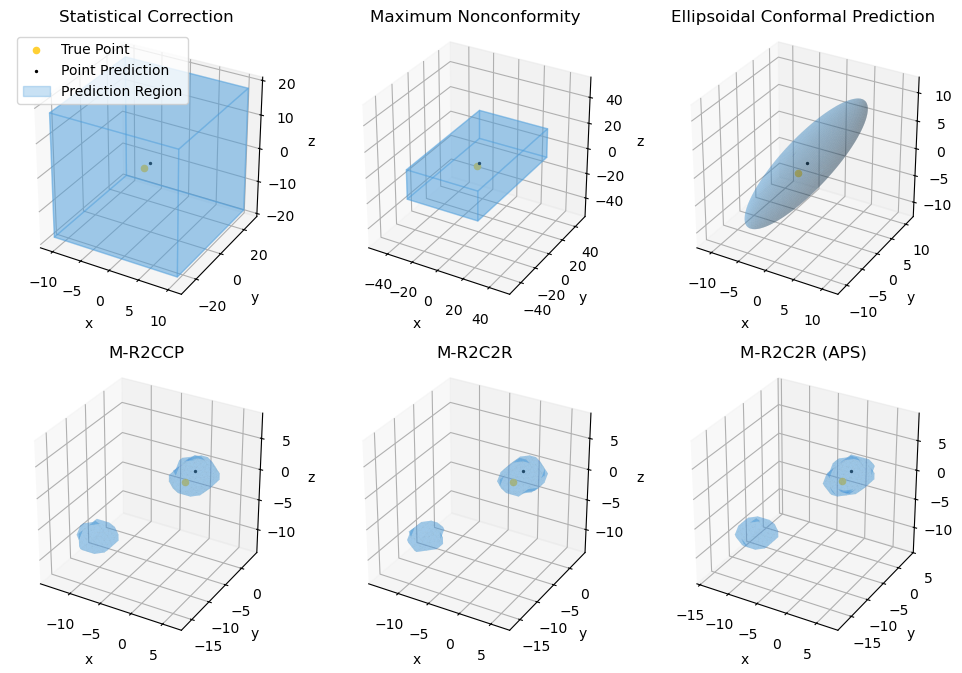

In [19]:
plot_single_landmark_sample(sample_idx=59, landmark_idx=4, save=True)